# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#from sklearn.neural_network import MLPRegressor

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
#test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
rid_oof = np.load("../input/tps-aug-2021-stacking-ridge-lv3/rid_oof.npy")
rid_pred = np.load("../input/tps-aug-2021-stacking-ridge-lv3/rid_pred.npy")

en_oof = np.load("../input/tps-aug-2021-stacking-en-lv3/en_oof.npy")
en_pred = np.load("../input/tps-aug-2021-stacking-en-lv3/en_pred.npy")

lgb_oof = np.load("../input/tps-aug-2021-stacking-lgb-no-pseudo/lgb_oof.npy")
lgb_pred = np.load("../input/tps-aug-2021-stacking-lgb-no-pseudo/lgb_pred.npy")


# Blending

In [6]:
def class_optimizer(X, a0, a1, a2):
    oof = X[0]*a0 + X[1]*a1 + (1-X[0]-X[1])*a2
    return mean_squared_error(train[target], oof, squared=False)

res = minimize(
    fun=class_optimizer,
    x0=[0.6, 0.3],
    args=tuple([rid_oof, en_oof, lgb_oof]),
    method='Nelder-Mead',
    options={'maxiter': 500})

print(res)
print(f"coef0 {res.x[0]}, coef1 {res.x[1]}, coef2 {1-res.x[0]-res.x[1]}")

 final_simplex: (array([[ 1.54631262, -0.02990933],
       [ 1.54640954, -0.02999759],
       [ 1.54625729, -0.02984123]]), array([7.80825461, 7.80825461, 7.80825461]))
           fun: 7.808254614628565
       message: 'Optimization terminated successfully.'
          nfev: 85
           nit: 44
        status: 0
       success: True
             x: array([ 1.54631262, -0.02990933])
coef0 1.54631262189876, coef1 -0.029909329334772597, coef2 -0.5164032925639873


In [7]:
blend_oof = res.x[0] * rid_oof + res.x[1] * en_oof + (1-res.x[0]-res.x[1]) * lgb_oof
blend_pred = res.x[0] * rid_pred  + res.x[1] * en_pred + (1-res.x[0]-res.x[1]) * lgb_pred

print(mean_squared_error(train[target], blend_oof, squared=False))

7.808254614628565


# OOF predictions

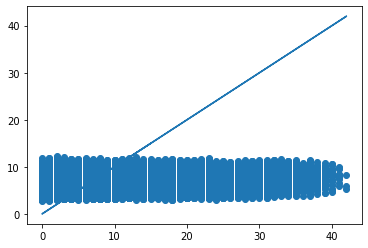

In [8]:
plt.plot(train[target], train[target])
plt.scatter(train[target], blend_oof)

# Submission

In [9]:
submission[target] = blend_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,7.824980
1,250001,5.601909
2,250002,9.133925
3,250003,8.076081
4,250004,6.514992
...,...,...
149995,399995,8.892393
149996,399996,8.068462
149997,399997,5.989622
149998,399998,5.156384
